In [45]:
from scipy.io.wavfile import read as wav_read
import numpy as np
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
import math
from scipy.signal import spectrogram
import subprocess as sp

%matplotlib inline

In [46]:
from warnings import warn

In [47]:
def normalize(wave):
    def unbias(wave):
        return wave - wave.mean()
    wave = unbias(wave)
    return wave / np.max(np.abs(wave))

In [48]:
cnt = 100

In [49]:
def run_ps(*args):
    sp.run(args, check=True)

In [50]:
def show(ys):
    ts = np.arange(ys.shape[0])
    plt.figure(figsize=(15, 6))
    plt.plot(ts, ys)

In [51]:
def get_pitch(wave, pos, length):
    # print(wave.shape, pos)
    wave = wave[pos:]
    wave = wave[:int(length / cnt * rate)]
    # wave = np.hamming(wave.shape[0]) * wave
    
    nwave = np.zeros(shape=wave.shape[0] * 2)
    nwave[:wave.shape[0]] = wave
    window = np.flipud(nwave)
    
    corr = ifft(fft(nwave) * fft(window)).real
    n = corr.shape[0]
    corr = np.roll(corr, n)[:n]
    
    # show(corr)
    # plt.show()
    
    corr = corr[:corr.shape[0] // 2]
    diff = np.diff(corr)
    maxs = np.argwhere(np.logical_and(diff[:-1] > 0, diff[1:] < 0)).squeeze()
    maxs = maxs[np.argwhere(corr[maxs] > 0.95 * corr[maxs].max()).squeeze()]
    # print(maxs)
    if len(maxs.shape) == 0:
        ind = int(maxs)
    else:
        ind = maxs[0]
    
    # print(ind)
    if ind == 1:
        show(corr)
    return rate / (ind + 2), rate / (ind if ind != 0 else 1)

In [52]:
'''
res = []
for pos in np.arange(10 / cnt, 11 / cnt, 1 / cnt):
    print('pos', pos, pos * rate, length)
    res.append(get_pitch(wave, int(pos * rate)))
print(res) '''

"\nres = []\nfor pos in np.arange(10 / cnt, 11 / cnt, 1 / cnt):\n    print('pos', pos, pos * rate, length)\n    res.append(get_pitch(wave, int(pos * rate)))\nprint(res) "

In [53]:
def determine(left, right):
    base = 440
    i1 = math.log(left / base) / math.log(2) * 12
    i2 = math.log(right / base) / math.log(2) * 12
    i1 = math.ceil(i1)
    i2 = math.floor(i2)
    if i1 == i2:
        return i1
    else:
        warn("choose between {}, {}".format(i1, i2))
        return i1

In [54]:
#rate, wave = wav_read('./rec_notes/katusha_long.wav')
rate, wave = wav_read('./rec_notes/katusha_long.wav')
wave = normalize(wave)
length = wave.shape[0] / rate
res = []
for pos in np.arange(0, length - 1 / cnt, 1 / cnt):
    pitch = get_pitch(wave, int(pos * rate), length)
    det = determine(*pitch)
    # print(pitch, det)
    res.append(det)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between 7, 6
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between -33, -34
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between -34, -35
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between 23, 24
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between 6, 5
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between -21, -22
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarni

In [55]:
def show_results(wave, rate, predict):
    predict = np.asanyarray(predict)
    wave = np.asanyarray(wave)
    fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))
    plt.plot(np.arange(0, len(predict) / cnt, 1 / cnt), 440 * 2 ** (predict / 12), color='black')
    plt.ylim(0, 4096 / 4)

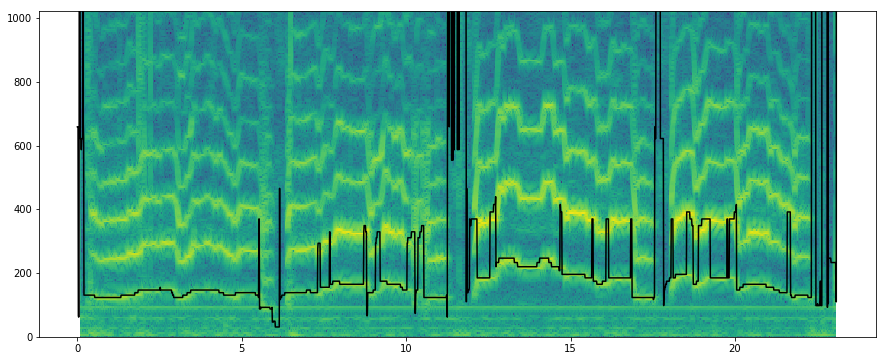

In [56]:
show_results(wave, rate, res)

In [17]:
fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
v = sxx[:500, int(rate * 13.2 // step)].ravel()
#v[:150] = 0

plt.figure(figsize=(15, 6))
plt.plot(fs[:500], v, color='black')
plt.show()
#(np.log(v))
#show(v)

NameError: name 'step' is not defined

In [18]:
step = 4096 * 2 // 8

IndexError: index 430 is out of bounds for axis 1 with size 428

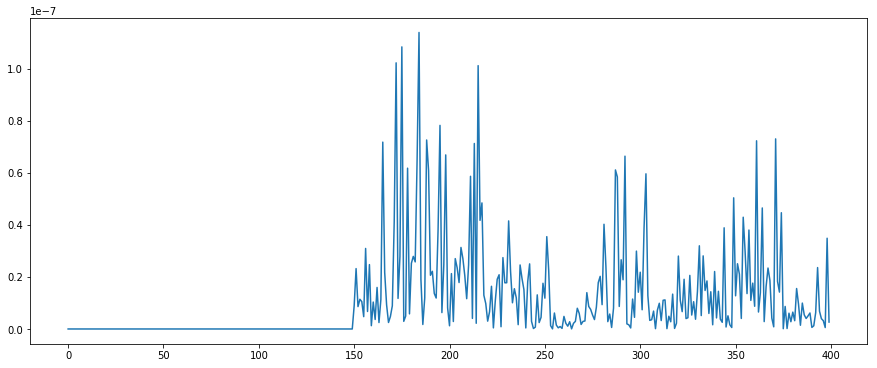

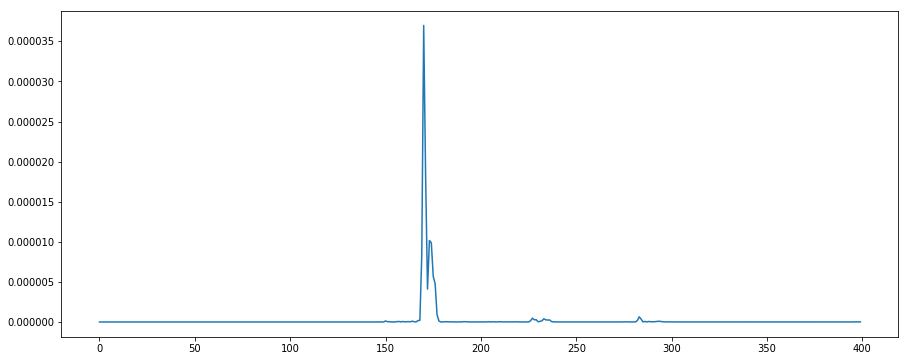

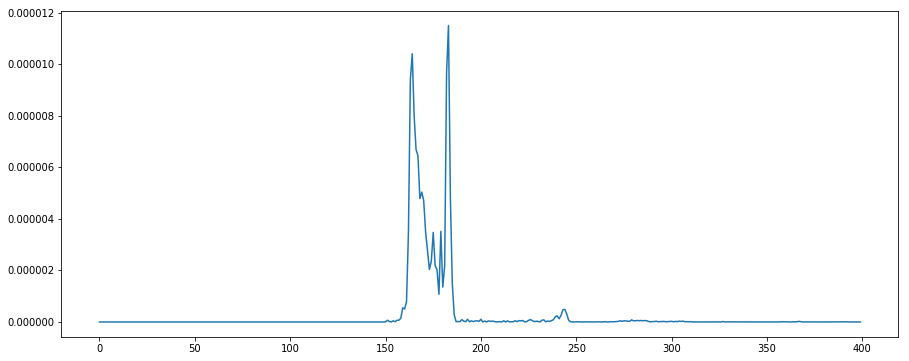

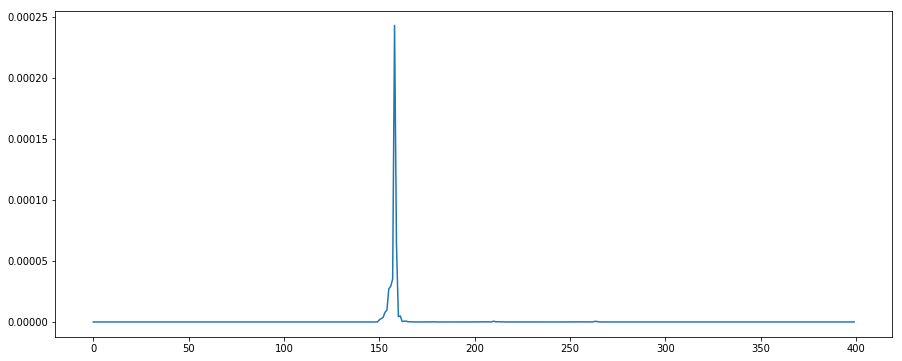

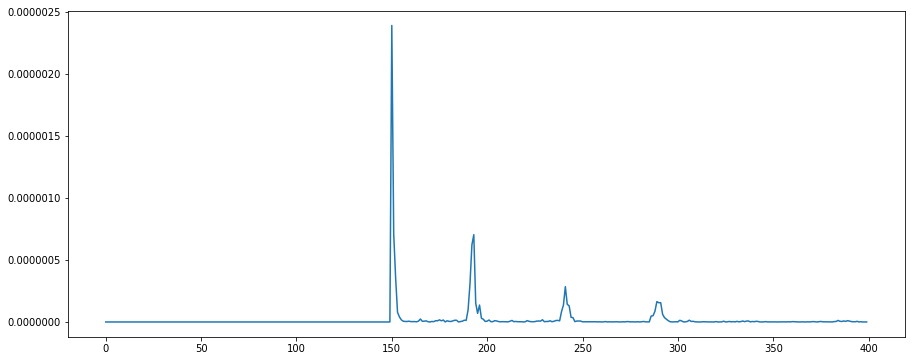

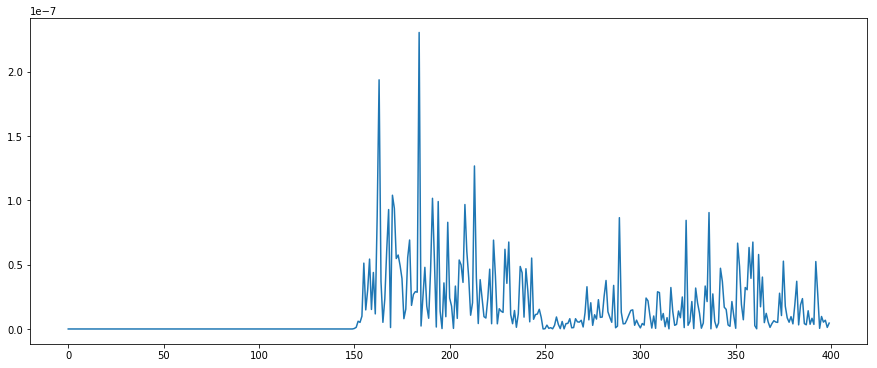

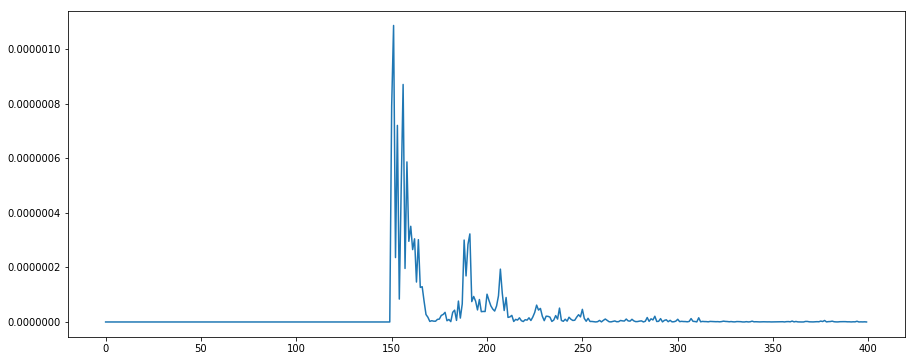

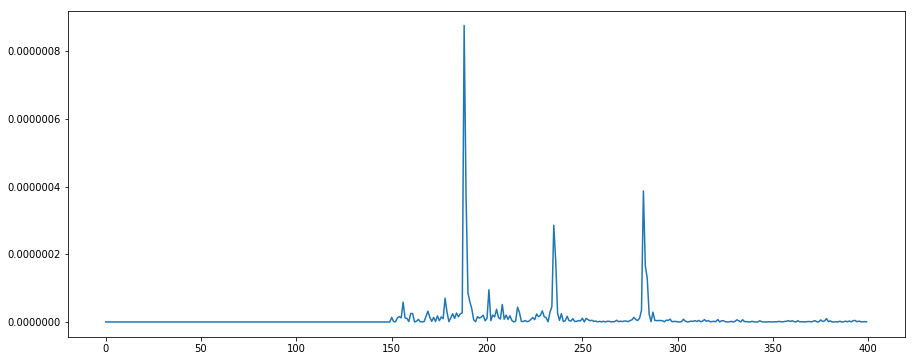

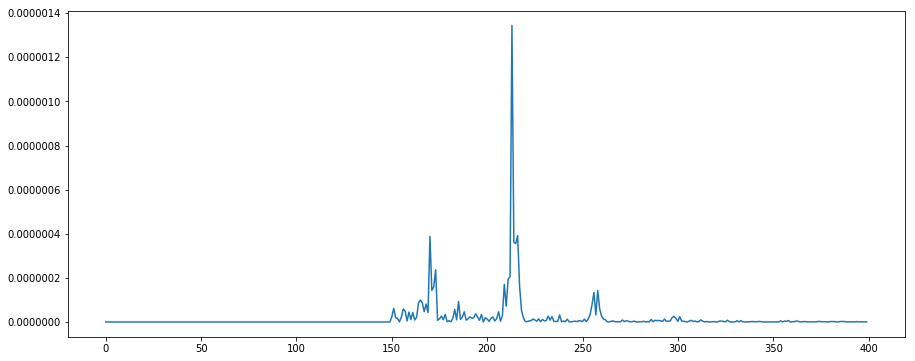

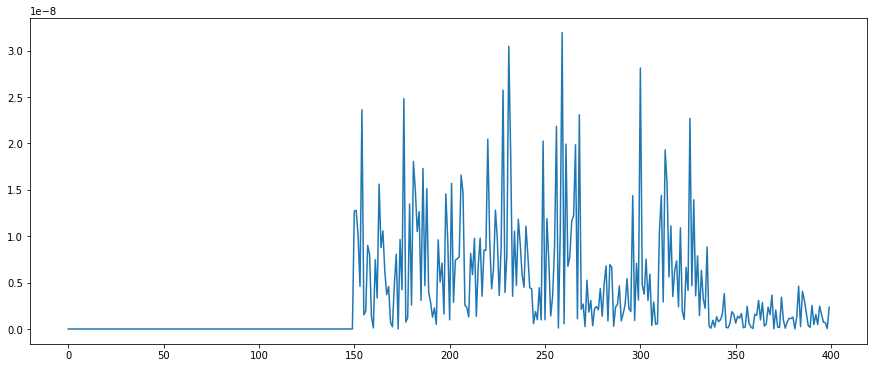

In [20]:
for i in range(17):
    v = sxx[:400, rate * i // step].ravel()
    v[:150] = 0
    show(v)
plt.savefig('out.svg')

In [21]:
def estimate_volume1(wave, framerate, seg_length):
    length = wave.shape[0] / framerate
    ts = []
    res = []
    for pos in np.arange(0, length, seg_length):
        left = int(pos * framerate)
        right = int((pos + seg_length) * framerate)
        seg = wave[left:right]
        if seg.shape[0] == 0:
            break
        ts.append(pos)
        res.append(np.mean(np.abs(seg)))
    return np.array(ts), np.array(res)

In [22]:
def estimate_volume2(wave, framerate, seg_length):
    length = wave.shape[0] / framerate
    ts = []
    res = []
    for pos in np.arange(0, length, seg_length):
        left = int(pos * framerate)
        right = int((pos + seg_length) * framerate)
        seg = wave[left:right].astype(np.float)
        if seg.shape[0] == 0:
            break
        ts.append(pos)
        res.append(np.mean(seg ** 2))
    return np.array(ts), np.array(res)

In [23]:
def estimate_volume3(wave, framerate, seg_length):
    length = wave.shape[0] / framerate
    ts = []
    res = []
    for pos in np.arange(0, length, seg_length):
        left = int(pos * framerate)
        right = int((pos + seg_length) * framerate)
        seg = wave[left:right].astype(np.float)
        if seg.shape[0] == 0:
            break
        ts.append(pos)
        res.append(np.max(np.abs(fft(seg))))
    return np.array(ts), np.array(res)

In [24]:
def split(predict, eps, k=10):
    res = []
    for i in range(k, len(predict)):
        if abs(predict[i] - predict[i - k]) > eps:
            res.append(i - k)
    return np.array(res)

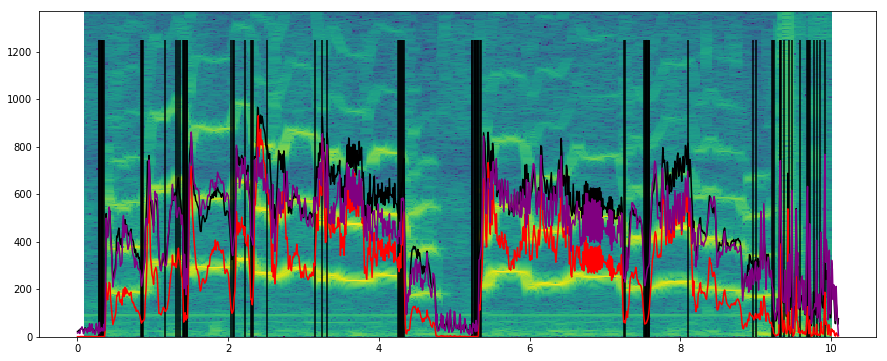

In [25]:
plt.figure(figsize=(15, 6))
ts, vol = estimate_volume1(wave, rate, 1 / cnt)
plt.plot(ts, vol * 3000, color='black')
ts, vol = estimate_volume2(wave, rate, 1 / cnt)
plt.plot(ts, vol * 6000, color='red')
ts, vol = estimate_volume3(wave, rate, 1 / cnt)
plt.plot(ts, vol * 10, color='purple')
spl = split(vol, 30)
plt.vlines(spl * ts[1], 0, 1250)
fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))

In [26]:
len(vol) // 7

144

# --------------------------

In [27]:
import peakutils

In [28]:
indexes = peakutils.indexes(v, thres=0.2, min_dist=0.1)
indexes

array([151, 154, 157, 161, 163, 165, 172, 174, 176, 179, 181, 184, 186,
       188, 194, 196, 198, 201, 206, 211, 213, 216, 218, 220, 224, 228,
       231, 234, 236, 240, 249, 251, 256, 259, 261, 266, 268, 282, 284,
       296, 298, 300, 303, 311, 313, 316, 319, 321, 324, 326, 328, 330, 335])

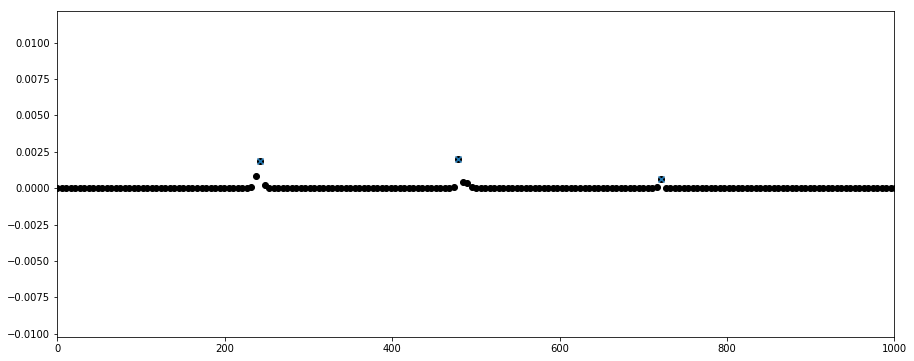

In [139]:
fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
v = sxx[:500, int(rate * 13.2 // step)].ravel()

plt.figure(figsize=(15, 6))
plt.scatter(fs[:500], v, color='black')
plt.scatter(fs[indexes], v[indexes], marker='x')
plt.xlim((0, 1000))
plt.show()

Получаем список разниц между слоями

In [135]:
differ_indexes = []
differ_values = []
for i in range(sxx.shape[1]):
    current_slice = sxx[:500, i].ravel()
    indexes = peakutils.indexes(current_slice, thres=0.3, min_dist=0.2)
    
    if len(indexes) > 1 and len(indexes) < 4:
        newvalue = np.average(fs[indexes[1:]] - fs[indexes[:-1]])
        differ_indexes.append(i)    indexes = peakutils.indexes(current_slice, thres=0.3, min_dist=0.2)
    
    if len(indexes) > 1 and len(indexes) < 4:
        newvalue = np.average(fs[indexes[1:]] - fs[indexes[:-1]])
        differ_indexes.append(i)
        differ_values.append(newvalue)
        differ_values.append(newvalue)

In [29]:
def show_results_difference(wave, rate, predict):
    predict = np.asanyarray(predict)
    wave = np.asanyarray(wave)
    fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))
    plt.plot(np.arange(0, len(predict) / cnt, 1 / cnt), 440 * 2 ** (predict / 12), color='black')
    plt.plot(ts[differ_indexes], differ_values, color='red')
    plt.ylim(0, 4096 / 4)

NameError: name 'differ_indexes' is not defined

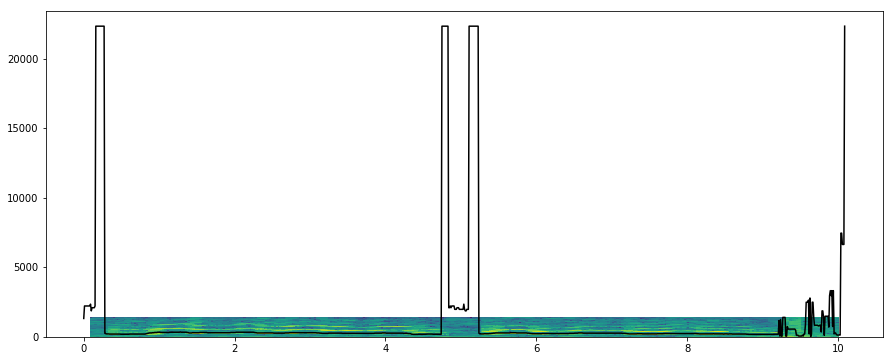

In [30]:
show_results_difference(wave, rate, res)

In [213]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

SyntaxError: invalid syntax (<ipython-input-213-eaa34fe2395f>, line 55)

In [31]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [32]:
from scipy.interpolate import UnivariateSpline

In [33]:
def show_results_filtered(wave, rate, predict, smooth, correcteddata, times, places):
    predict = np.asanyarray(predict)
    wave = np.asanyarray(wave)
    fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))
    plt.plot(np.arange(0, len(predict) / cnt, 1 / cnt), 440 * 2 ** (predict / 12), color='black')
    plt.plot(times, 440 * 2 ** (predict / 12), color='black')
    plt.plot(times, 440 * 2 ** (smooth / 12), color='red')
    plt.plot(times, 440 * 2 ** (correcteddata / 12), color='blue')
    
    
    plt.vlines(times[places], 0, 100, color='green')
    
    plt.ylim(0, 4096 / 4)
    #plt.xlim((11, 20))
    plt.show()

In [34]:
SMOOTH_FACTOR = 0.5
MAX_PEAK_LENGTH = 50

def filter_lunges(wave, rate, olddata):
    
    times = np.arange(0, len(olddata) / cnt, 1 / cnt)
    
    data = olddata[:]

    # data = np.array([data]) 
    
    print(times.shape)
    
    #print(data.shape)
    smooth_data = movingaverage(data, 70) #UnivariateSpline(times, data.ravel(), s=0.05)(times)
    #smooth_data = UnivariateSpline(times, data.ravel(), s=50000, k=2)(times)
    

    i = 1
    places = []
    while i < len(data):
        print(i)
        
        
        j = 0
        
        if np.abs(data[i] - smooth_data[i]) > SMOOTH_FACTOR * np.abs(smooth_data[i]):
            last_sign = data[i] - smooth_data[i-1]
            places.append(i)
            print('peak in', i, 'data[i]=', data[i], 'data[i-1]=', data[i-1], 'smdata=', smooth_data[i])
            delta = data[i] - data[i-1]
            start_value = data[i-1]
            print('delta = ', delta)
            while j < MAX_PEAK_LENGTH and i + j < len(data) :                
                if (not (np.abs(data[i+j] - smooth_data[i+j]) > SMOOTH_FACTOR * np.abs(smooth_data[i+j]))) or (data[i+j] - smooth_data[i+j]) * last_sign < 0:
                    if (data[i+j] - smooth_data[i+j]) * last_sign < 0:
                        j -= 1
                    print('breakin')
                    break
                # data[i+j] = start_value + (start_value + data[i+j] % 12)# += delta
                data[i+j] -= delta
                j += 1
        i = i + j + 1    
    
    show_results_filtered(wave, rate, olddata, smooth_data, np.array(data), times.ravel(), places)
    
    return data       
                
                    
        
        
#         l = (i - PEAK_WIDTH if i - PEAK_WIDTH > 0 else 0)
#         r = (i + PEAK_WIDTH if i + PEAK_WIDTH < len(data) else len(data) - 1)
#         current_slice = data[l:r]

        

#         peakutils.indexes(v, thres=0.2, min_dist=0.1)
    
    
    

(1010,)
1
peak in 1 data[i]= 28 data[i-1]= 19 smdata= 16.4
delta =  9
breakin
28
peak in 28 data[i]= -10 data[i-1]= 59 smdata= 10.8285714286
delta =  -69
breakin
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280


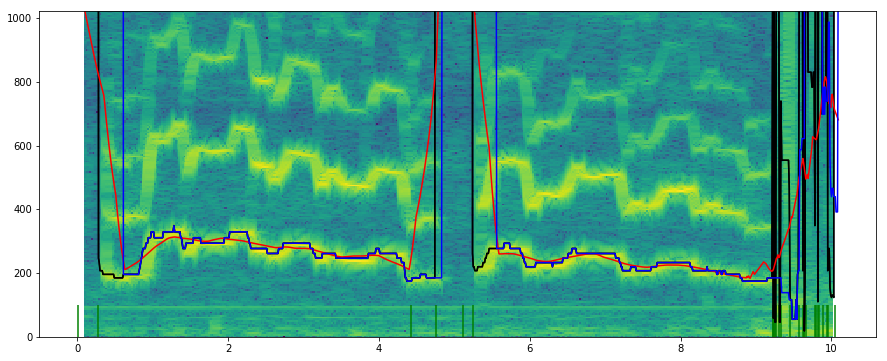

In [35]:
near_notes = filter_lunges(wave, rate, res)

ЭТО поиск тишины

In [400]:
cnt_per_sec = 10

In [401]:
def est1(seg):
    return np.mean(np.abs(seg))

In [402]:
def get_silence(wave):
    segs_num = int(length * cnt_per_sec)
    is_silence = np.zeros(shape=segs_num)
    for i in range(segs_num):
        s1 = rate * i // cnt_per_sec
        s2 = rate * (i + 1) // cnt_per_sec
        vol = est1(wave[s1:s2])
        is_silence[i] = 1 if vol > 0.02 else 0
    return is_silence

# ПИЛИКАЛКА

In [36]:
import numpy as np

from scipy.io import wavfile

from os import listdir
from os.path import isfile, join
import re
import subprocess as sp
import tempfile
import os

def normalize(wave):
    def unbias(wave):
        return wave - wave.mean()
    wave = unbias(wave)
    return wave / np.max(np.abs(wave))

def convert_freq(wave, fr_from, fr_to):
    # print(fr_from, fr_to)
    if fr_from == fr_to:
        return wave
    with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as f1, \
            tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as f2:
        f1.close()
        f2.close()
        wavfile.write(f1.name, fr_from, wave)
        sp.check_call(['ffmpeg', '-y', '-i', f1.name, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', 
                str(fr_to), f2.name])
#         sp.run(['ffmpeg', '-y', '-i', f1.name, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', 
#                 str(fr_to), f2.name], check=True)
        out_rate, out_wave = wavfile.read(f2.name)
        os.unlink(f1.name)
        os.unlink(f2.name)
        return out_wave

SOURCE_FOLDER = './Norm_packs/rendered_/'
SHIFT = 37

class AudioBuilder:
    def __init__(self, length, rate):
        self.rate = rate
        self.data = np.zeros(shape=int(length * rate))
        self.wavs = []
        names = [f for f in listdir(SOURCE_FOLDER) if isfile(join(SOURCE_FOLDER, f))]
        names.sort()
        for filename in names:
            fr, wave = wavfile.read(SOURCE_FOLDER + filename)
            self.wavs.append(convert_freq(wave[:, 0], fr, rate))
    def add_wave(self, wave, pos):
        wave = normalize(wave)
        self.data[pos:wave.shape[0]] += wave
    def add_freq(self, note, pos, dur=None, amp=1.0):
        max_dur = self.wavs[note].shape[0]
        if dur is None:
            dur = max_dur
        if dur > max_dur:
            dur = max_dur
        if dur + pos > self.data.shape[0]:
            dur = self.data.shape[0] - pos
        note += 36
#         print(dur)
        if 0 <= note < len(self.wavs):
            self.data[pos:pos+dur] += self.wavs[note][:dur] * amp
    def build(self):
        return normalize(self.wave)
    def write(self, filename):
        wavfile.write(filename, self.rate, normalize(self.data))

Пример использования

In [37]:
r = 44100
builder = AudioBuilder(length=3.0, rate=r)


builder.add_freq(0, 0, dur=r // 4)
builder.add_freq(2, r // 2, amp=0.5, dur=r // 4)
builder.add_freq(4, r, amp=0.25, dur=r // 4)
builder.write('output.wav')

In [38]:
import sys
sys.version

'3.4.3 (default, Nov 17 2016, 01:08:31) \n[GCC 4.8.4]'

In [39]:
def float_to_time(ind, rate):
    return int(ind * rate)

In [43]:
r = 44100
builder = AudioBuilder(length=25.0, rate=r)

lsize = len(near_notes)
times = np.arange(0, len(near_notes) / cnt, 1 / cnt)

for i in range(0, lsize, 5):
    builder.add_freq(near_notes[i], float_to_time(times[i], r), dur=float_to_time(5 / cnt, r))

builder.write('output.wav')

In [463]:
times

array([  0.00000000e+00,   1.00000000e-02,   2.00000000e-02, ...,
         2.31200000e+01,   2.31300000e+01,   2.31400000e+01])

In [ ]:
def get_notes(near):
    times = np.arange(0, len(near) / cnt, 1 / cnt)
    data = olddata[:]

    